# Planetary Satellites

Planetary satellites have very different orbits compared to small bodies. N-body simulations for these satellites are more complex due to their proximity to other satellites in the planetary system and the non-spherical shape of their parent planets. Therefore, it is more practical to use SPICE kernels rather than running our own N-body simulations (e.g., with kete). Additionally, kete lacks the functionality to handle satellites, as it cannot even read satellite SPICE kernels.

## Preparation
The SPICE kernels for the planetary satellites are unfortunately scattered across multiple files. These are at JPL's ftp web [link](https://ssd.jpl.nasa.gov/sats/ephem/files.html). Not all satellites are in a single BSP file (e.g., Jupiter moons are separately stored in `jup344.bsp`, `jup346.bsp`, and `jup365.bsp`, due to different references). See the summary at [JPL](https://ssd.jpl.nasa.gov/sats/ephem/).

As of Dec 2024, I find the following files can include all satellites covering the next decade (each of them downloadable [here](https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/satellites/)):

```
    mar097.bsp
    jup344.bsp, jup346.bsp, jup365.bsp
    sat415.bsp, sat441.bsp, sat454.bsp
    ura111.bsp, ura115.bsp, ura117.bsp
    nep095.bsp, nep104.bsp
    plu060.bsp
```

Using SPICE toolkit's [`SPKMERGE`](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/ug/spkmerge.html), one can merge them with specific begin/end times to minimize the size of the merged file. How? Prepare `spkmerge_setup.txt` as:
```
LEAPSECONDS_KERNEL    = lsk/naif0012.tls
SPK_KERNEL            = satellites_2025-2027.bsp
   BEGIN_TIME            = 2024-12-31T00:00:00
   END_TIME              = 2028-01-01T23:59:59
   SOURCE_SPK_KERNEL     = nep104.bsp
   SOURCE_SPK_KERNEL     = jup365.bsp
   SOURCE_SPK_KERNEL     = ura111.bsp
   SOURCE_SPK_KERNEL     = sat415.bsp
   SOURCE_SPK_KERNEL     = ura115.bsp
   SOURCE_SPK_KERNEL     = ura117.bsp
   SOURCE_SPK_KERNEL     = jup344.bsp
   SOURCE_SPK_KERNEL     = mar097.bsp
   SOURCE_SPK_KERNEL     = jup346.bsp
   SOURCE_SPK_KERNEL     = nep095.bsp
   SOURCE_SPK_KERNEL     = sat441.bsp
   SOURCE_SPK_KERNEL     = plu060.bsp
   SOURCE_SPK_KERNEL     = sat454.bsp
```

* **NOTE**: I added ± 1 day margin to the BEGIN_TIME and END_TIME. Otherwise, SPICE calculation for 2025-01-01.00 or 2027-12-31.99 **may** fail because the objects' information slightly outside the time range is required due to the light-time delay.

Then prepare `lsk/naif0012.tls` (or change as you wish). Put the above `.bsp` files properly at the directory you want. Run 

    $ spkmerge spkmerge_setup.txt
    
You must have SPICE toolkits installed. This will generate `satellites_2025-2027.bsp`. It is ~130MB (as of writing). If the timespan is changed to 2035, the file size is roughly 3.5x larger (480MB).

Unfortunately, they are in type 3 DAF. kete currently cannot read them, so let's use spiceypy.

In [1]:
import skyloc as sloc
import spiceypy as sp

# Specify the kernels to load, and save meta kernel
sloc.spicetools.make_meta(
    "$KERNELS/lsk/naif0012.tls",
    "$KERNELS/pck/gm_de440.tpc",
    "$KERNELS/pck/pck00011.tpc",
    "$KERNELS/satellites_2025-2027.bsp",
    output="meta.mk"
)
# Load the kernels
handle = sp.furnsh("meta.mk")

Calculate the satellites' state vector at a given time by [`spkezr`](https://spiceypy.readthedocs.io/en/latest/documentation.html#spiceypy.spiceypy.spkezr):

In [2]:
sp.spkezr(
    "TITAN", sp.str2et("2025-12-12T00:00:00"), ref="J2000", abcorr="NONE", obs="JUPITER"
)

(array([ 1.65474840e+09, -6.39480562e+08, -3.41108850e+08,  1.70444126e+01,
         9.87273653e+00,  4.43029579e+00]),
 6025.872905356639)

Try `abcorr` of ``"LT"``, ``"LT+S"``, ``"CN"`` and ``"CN+S"``.

(Readers from the future: Please consider using spiceypy's cyice. It is not available as of writing, 2025 Jun).

Or using convenience function within `skyloc.spicetools`:

In [3]:
times, ets = sloc.spicetools.times2et(["2025-01-01", "2025-01-02"])
# times : astropy Time object
# ets : list of ET values (list of float)
for et in ets:
    sta, lt = sp.spkezr("TITAN", et, ref="J2000", abcorr="NONE", obs="JUPITER")
    print(et)
    print(sta, lt)

788961669.1839275
[ 1.25847909e+09 -9.06164937e+08 -4.42362847e+08  1.21446916e+01
  1.11678577e+01  1.81843771e+00] 5379.169023917955
789048069.1839565
[ 1.25944289e+09 -9.05247324e+08 -4.42194543e+08  1.02559316e+01
  9.94557176e+00  2.07739937e+00] 5379.805795426772


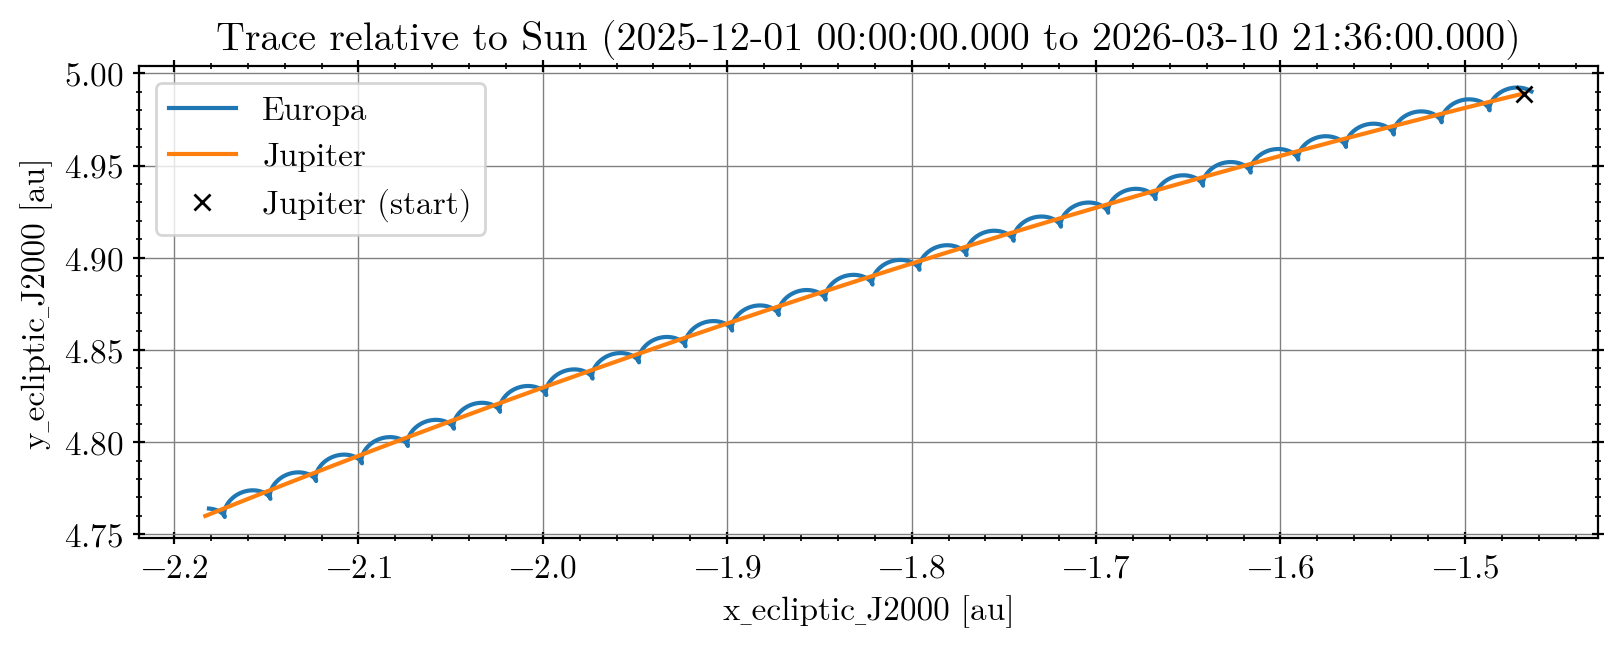

In [ ]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
from astropy.time import Time
from astropy import units as u

%config InlineBackend.figure_format = 'retina'
# %matplotlib notebook
InteractiveShell.ast_node_interactivity = 'last_expr'

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})


times, ets = sloc.spicetools.times2et(
    Time("2025-12-01", format="iso", scale="utc") + np.arange(0, 100, 0.1)*u.day
)
states = []
states_jup = []

for et in ets:
    states.append(
        sp.spkezr("EUROPA", et, ref="ECLIPJ2000", abcorr="NONE", obs="SUN")[0]
    )
    states_jup.append(
        sp.spkezr("JUPITER", et, ref="ECLIPJ2000", abcorr="NONE", obs="SUN")[0]
    )

states = np.array(states)
states_jup = np.array(states_jup)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

km2au = sp.convrt(1, "km", "au")

axs.plot(states[:, 0]*km2au, states[:, 1]*km2au, label="Europa")
axs.plot(states_jup[:, 0]*km2au, states_jup[:, 1]*km2au, label="Jupiter")
axs.plot(states_jup[0, 0]*km2au, states_jup[0, 1]*km2au, "kx", label="Jupiter (start)")

axs.set_aspect("equal")
axs.set(
    title=f"Trace relative to Sun ({times[0].iso} to {times[-1].iso})",
    xlabel="x_ecliptic_J2000 [au]", ylabel="y_ecliptic_J2000 [au]"
)
axs.legend()
plt.show();